In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.utilities import vocabulary, NUM_EPOCHS, EMBEDDING_LEN, HIDDEN_SIZE
from src.train_sampler_class import TrainSampler
from src.RNN_model_class import RNN

In [2]:
train_sampler = TrainSampler(vocabulary=vocabulary)
rnn = RNN(embedding_dim=EMBEDDING_LEN,
          hidden_size=HIDDEN_SIZE,
          word_sampler=train_sampler)

In [3]:
rnn.fit(num_epochs=NUM_EPOCHS)

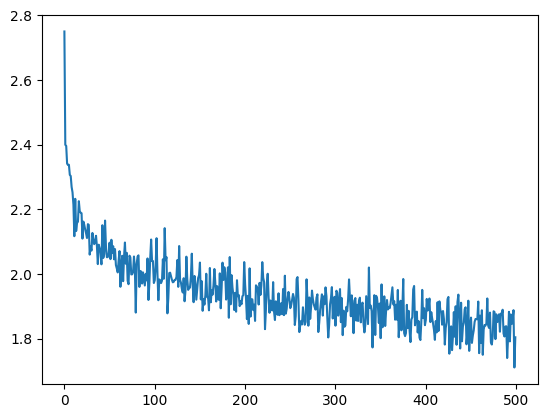

In [4]:
plt.plot(np.array(rnn.train_losses).reshape(-1, 100).mean(axis=1))

In [6]:
rnn.predict(5)

['rtin', 'vynn', 'rek', 'nellio', 'zean']

In [ ]:
# def build_train(words: list):
#     """Function beaks down every word from passed list into train and target samples"""
#     X = []; y=[]
#     for word in words:
#         context = '.' * CONTEXT_LEN
#         for ch in word + '.':
#             X.append(word2vec(context)); y.append(word2vec(ch))
#             context = context[1:] + ch
#     return torch.tensor(X), torch.tensor(y).float()